In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa

In [2]:
def load_patient_data(patient_id, location):

    wav_file = f'dataset/training_data/{patient_id}_{location}.wav'
    hea_file = f'dataset/training_data/{patient_id}_{location}.hea'
    tsv_file = f'dataset/training_data/{patient_id}_{location}.tsv'
    txt_file = f'dataset/training_data/{patient_id}.txt'
     
    fs, audio = wavfile.read(wav_file)
 
    with open(hea_file, 'r') as f:
        hea_data = f.readlines()
    hea_info = hea_data[0].split()
    fs = int(hea_info[2]) 
     
    segmentation = pd.read_csv(tsv_file, sep='\t', header=None)
    segmentation.columns = ['Start', 'End', 'State']
 
    demographics = {}
    with open(txt_file, 'r') as f:
        txt_data = f.readlines()
    for line in txt_data:
        if line.startswith('#'):
            key, value = line[1:].strip().split(': ')
            demographics[key] = value
    
    return fs, audio, segmentation, demographics

In [3]:
def plot_heart_sound(audio, fs, segmentation, title='Heart Sound Signal', max_time=None):
    time = np.arange(len(audio)) / fs
    
    if max_time is not None: 
        max_idx = int(max_time * fs)
        time = time[:max_idx]
        audio = audio[:max_idx]
        segmentation = segmentation[segmentation['End'] <= max_time]   
    
    plt.figure(figsize=(10, 6))
    plt.plot(time, audio, label='Heart Sound Signal', alpha=0.6)
     
    for _, row in segmentation.iterrows():
        start, end, state = row
        if state == 1:
            plt.axvspan(start, end, color='green', alpha=0.3, label='S1' if 'S1' not in plt.gca().get_legend_handles_labels()[1] else "")
        elif state == 2:
            plt.axvspan(start, end, color='yellow', alpha=0.3, label='Systole' if 'Systole' not in plt.gca().get_legend_handles_labels()[1] else "")
        elif state == 3:
            plt.axvspan(start, end, color='blue', alpha=0.3, label='S2' if 'S2' not in plt.gca().get_legend_handles_labels()[1] else "")
        elif state == 4:
            plt.axvspan(start, end, color='red', alpha=0.3, label='Diastole' if 'Diastole' not in plt.gca().get_legend_handles_labels()[1] else "")
    
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

In [4]:
patient_id = '2530'
location = 'AV'
fs, audio, segmentation, demographics = load_patient_data(patient_id, location)
 
demographics_df = pd.DataFrame(list(demographics.items()), columns=['Attribute', 'Value'])

demographics_df

,Attribute,Value
0,Age,Child
1,Sex,Female
2,Height,98.0
3,Weight,15.9
4,Pregnancy status,False
5,Murmur,Absent
6,Murmur locations,nan
7,Most audible location,nan
8,Systolic murmur timing,nan
9,Systolic murmur shape,nan


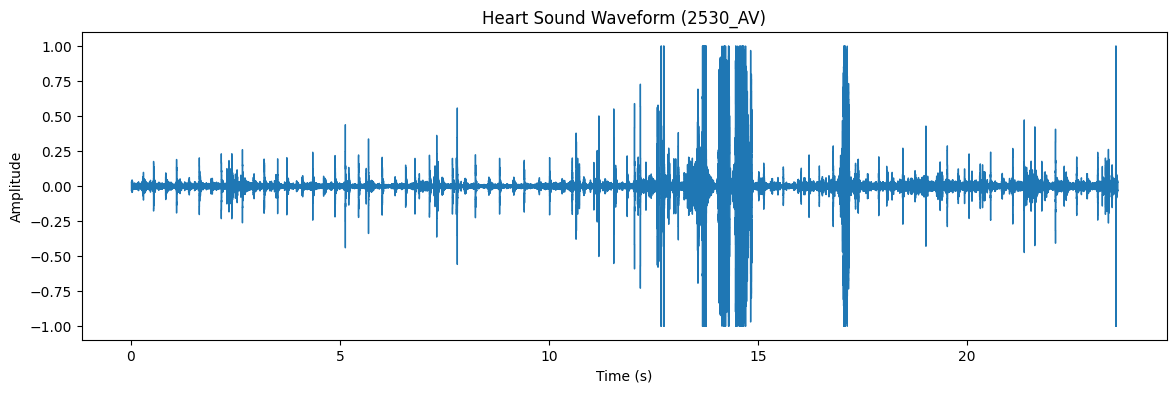

In [5]:
audio_file = 'dataset/training_data/2530_AV.wav'
y, sr = librosa.load(audio_file, sr=None)
 
segmentation_file = 'dataset/training_data/2530_AV.tsv'
segments = np.loadtxt(segmentation_file)

plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Heart Sound Waveform (2530_AV)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

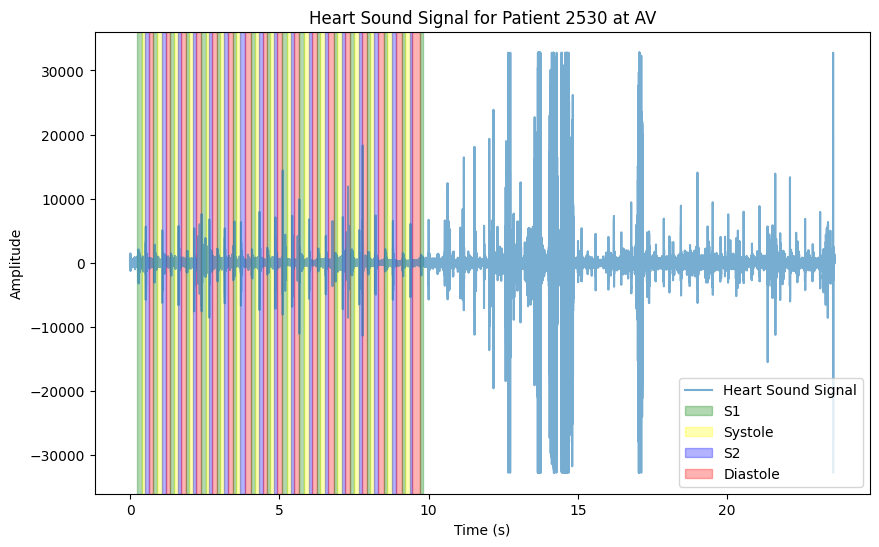

In [6]:
patient_id = '2530'
location = 'AV'
fs, audio, segmentation, demographics = load_patient_data(patient_id, location)
plot_heart_sound(audio, fs, segmentation, title=f'Annotated Heart Sound Signal for Patient {patient_id} at {location}')

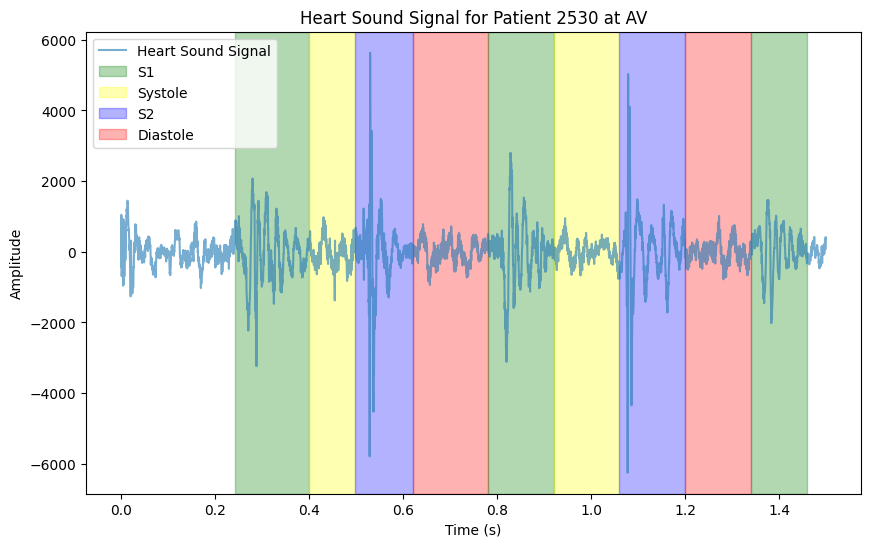

In [7]:
time = 1.5
plot_heart_sound(audio, fs, segmentation, title=f'Annotated Heart Sound Signal for Patient {patient_id} at {location}',max_time=time)

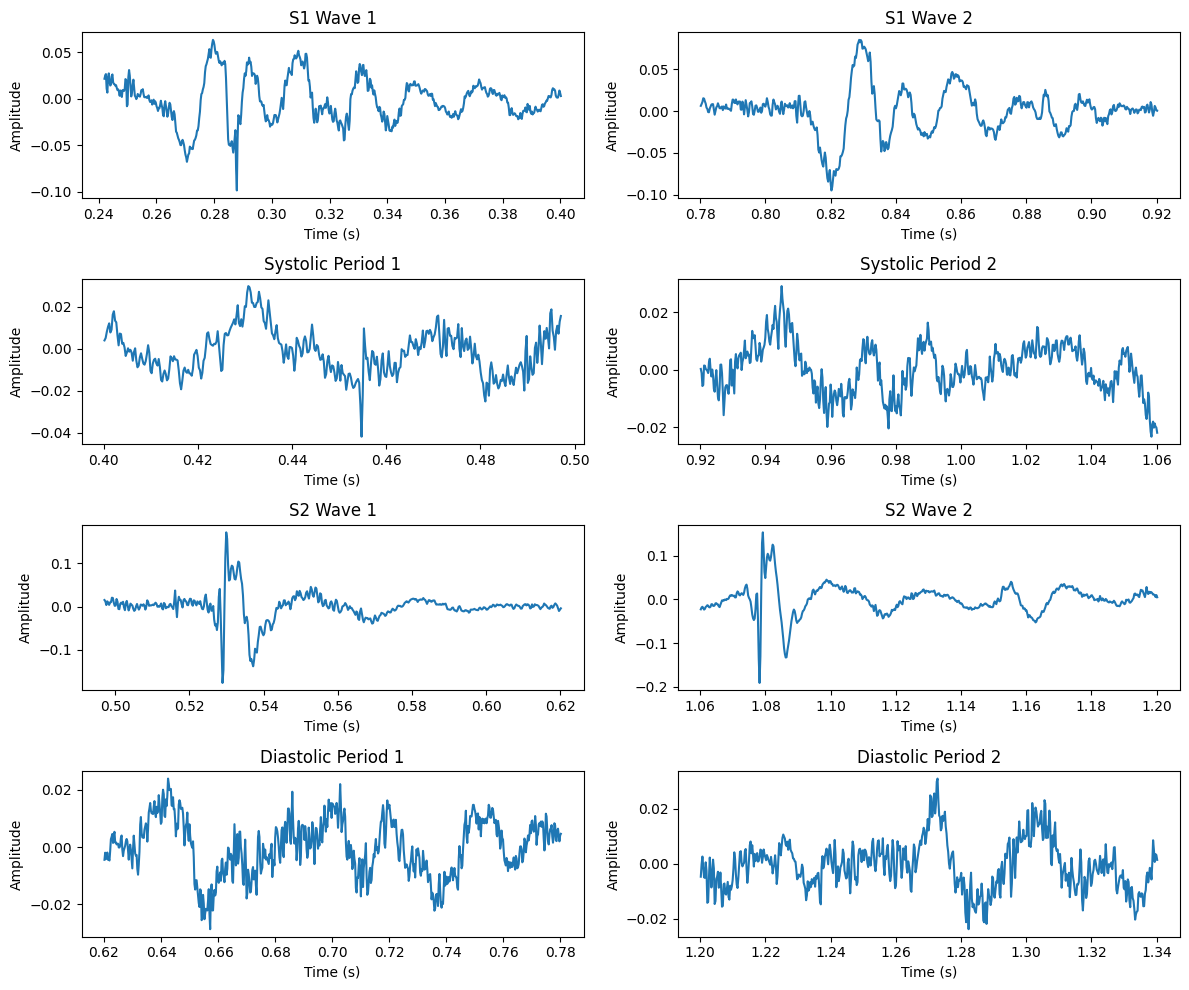

In [15]:
s1_count = 0
systolic_count = 0
s2_count = 0
diastolic_count = 0
 
fig, axs = plt.subplots(4, 2, figsize=(12, 10))
axs = axs.flatten()

for start, end, label in segments:
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    x = np.linspace(start, end, end_sample - start_sample)
    y_data = y[start_sample:end_sample]
    
    if label == 1 and s1_count < 2:  # S1 wave
        axs[s1_count].plot(x, y_data)
        axs[s1_count].set_title(f'S1 Wave {s1_count + 1}')
        axs[s1_count].set_xlabel('Time (s)')
        axs[s1_count].set_ylabel('Amplitude')
        s1_count += 1

    elif label == 2 and systolic_count < 2:  # Systolic period
        axs[2 + systolic_count].plot(x, y_data)
        axs[2 + systolic_count].set_title(f'Systolic Period {systolic_count + 1}')
        axs[2 + systolic_count].set_xlabel('Time (s)')
        axs[2 + systolic_count].set_ylabel('Amplitude')
        systolic_count += 1

    elif label == 3 and s2_count < 2:  # S2 wave
        axs[4 + s2_count].plot(x, y_data)
        axs[4 + s2_count].set_title(f'S2 Wave {s2_count + 1}')
        axs[4 + s2_count].set_xlabel('Time (s)')
        axs[4 + s2_count].set_ylabel('Amplitude')
        s2_count += 1

    elif label == 4 and diastolic_count < 2:  # Diastolic period
        axs[6 + diastolic_count].plot(x, y_data)
        axs[6 + diastolic_count].set_title(f'Diastolic Period {diastolic_count + 1}')
        axs[6 + diastolic_count].set_xlabel('Time (s)')
        axs[6 + diastolic_count].set_ylabel('Amplitude')
        diastolic_count += 1

    if s1_count >= 2 and systolic_count >= 2 and s2_count >= 2 and diastolic_count >= 2:
        break

plt.tight_layout()
plt.show()


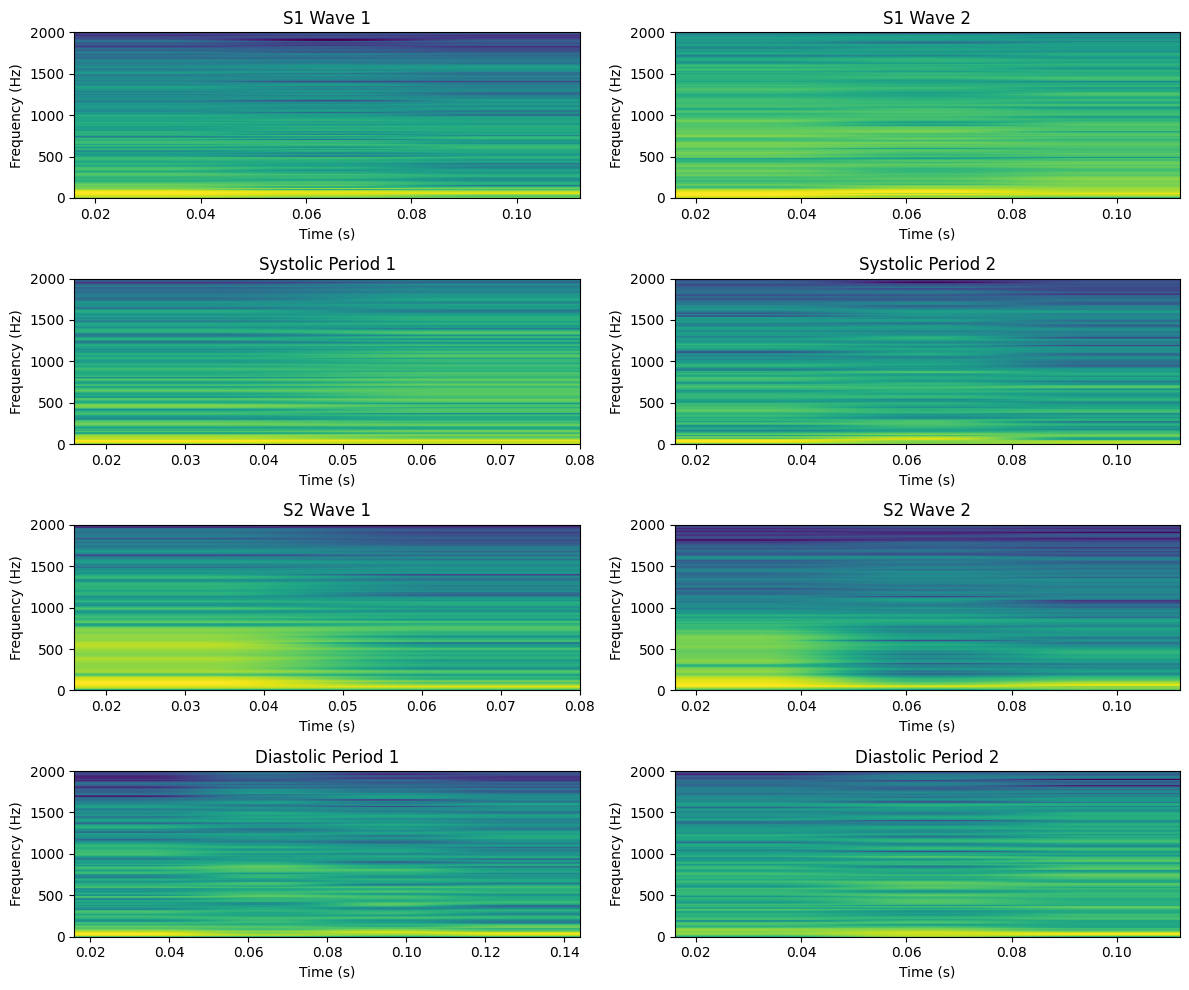

In [19]:
s1_count = 0
systolic_count = 0
s2_count = 0
diastolic_count = 0
 
fig, axs = plt.subplots(4, 2, figsize=(12, 10))
axs = axs.flatten()

for start, end, label in segments:
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    y_data = y[start_sample:end_sample]
    
    if label == 1 and s1_count < 2:  # S1 wave
        axs[s1_count].specgram(y_data, NFFT=256, Fs=sr, cmap='viridis')
        axs[s1_count].set_title(f'S1 Wave {s1_count + 1}')
        axs[s1_count].set_xlabel('Time (s)')
        axs[s1_count].set_ylabel('Frequency (Hz)')
        s1_count += 1

    elif label == 2 and systolic_count < 2:  # Systolic period
        axs[2 + systolic_count].specgram(y_data, NFFT=256, Fs=sr, cmap='viridis')
        axs[2 + systolic_count].set_title(f'Systolic Period {systolic_count + 1}')
        axs[2 + systolic_count].set_xlabel('Time (s)')
        axs[2 + systolic_count].set_ylabel('Frequency (Hz)')
        systolic_count += 1

    elif label == 3 and s2_count < 2:  # S2 wave
        axs[4 + s2_count].specgram(y_data, NFFT=256, Fs=sr, cmap='viridis')
        axs[4 + s2_count].set_title(f'S2 Wave {s2_count + 1}')
        axs[4 + s2_count].set_xlabel('Time (s)')
        axs[4 + s2_count].set_ylabel('Frequency (Hz)')
        s2_count += 1

    elif label == 4 and diastolic_count < 2:  # Diastolic period
        axs[6 + diastolic_count].specgram(y_data, NFFT=256, Fs=sr, cmap='viridis')
        axs[6 + diastolic_count].set_title(f'Diastolic Period {diastolic_count + 1}')
        axs[6 + diastolic_count].set_xlabel('Time (s)')
        axs[6 + diastolic_count].set_ylabel('Frequency (Hz)')
        diastolic_count += 1

    if s1_count >= 2 and systolic_count >= 2 and s2_count >= 2 and diastolic_count >= 2:
        break

plt.tight_layout()
plt.show()
